In [1]:
import os
import sys
import tempfile
import pandas as pd

from CoolProp.CoolProp import PropsSI

import matplotlib.pyplot as plt
%matplotlib inline

cwd = os.getcwd()
sys.path.append(os.path.normpath(os.path.join(cwd, '..', '..', '..', 'glhe')))
sys.path.append(os.path.normpath(os.path.join(cwd, '..', '..', '..', 'standalone')))

In [2]:
from standalone import run_g_function

In [3]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [15, 9]
plt.rcParams['font.size'] = 14

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [4]:
df = pd.read_csv('data.csv', parse_dates=True, index_col='Date/Time')

In [5]:
df.head(1)

,AC Voltage [VAC],DC Voltage [VDC],Flow Meter [GPM],Air Temp [C],Inlet 1 [C],Outlet 1 [C],Inlet 2 [C],Outlet 2 [C],Base Heater [W},Var. Heater [W],Pump Watts [W],Pump Volts [VAC],Pump Amps [Amps],SCR Output [VDC],Calc Pump Power [W],Flow [L/s],mdot [kg/s],cp [J/kg-K],Inst. HT [1] [W],Inst. HT [2] [W],Meas. Total Power [W],Est. Pump Power [W],Inlet [1] - Inlet [2] [C],Outlet [1] - Outlet [2] [C],Bits,FFP,DT [1] - DT [2] [C],MFT [1] [C],MFT [2] [C]
Date/Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-12-20 12:05:54,0.135911,0.002987,4.655363,12.483983,16.074835,16.107059,16.069417,16.163488,99.1085,76.4628,254.1525,127.45404,1.83093,0.938138,233.359425,0.293708,0.293393,4185.34385,39.569556,115.514676,389.281862,213.710562,0.005418,-0.056429,78.94109,0.419335,-0.061847,16.090947,16.088238


In [6]:
df = df.resample('1H').mean()

In [7]:
df.head(1)

,AC Voltage [VAC],DC Voltage [VDC],Flow Meter [GPM],Air Temp [C],Inlet 1 [C],Outlet 1 [C],Inlet 2 [C],Outlet 2 [C],Base Heater [W},Var. Heater [W],Pump Watts [W],Pump Volts [VAC],Pump Amps [Amps],SCR Output [VDC],Calc Pump Power [W],Flow [L/s],mdot [kg/s],cp [J/kg-K],Inst. HT [1] [W],Inst. HT [2] [W],Meas. Total Power [W],Est. Pump Power [W],Inlet [1] - Inlet [2] [C],Outlet [1] - Outlet [2] [C],Bits,FFP,DT [1] - DT [2] [C],MFT [1] [C],MFT [2] [C]
Date/Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-12-20 12:00:00,193.629484,4.28416,4.767731,23.499698,20.242131,23.087938,20.249176,23.106794,2308.350415,1209.753061,265.307005,129.568936,1.858817,0.933167,240.845114,0.300797,0.300142,4180.996175,3572.015309,3586.840268,3738.669431,220.565955,-0.007045,-0.018856,78.655326,0.416141,-0.011811,21.665034,21.668557


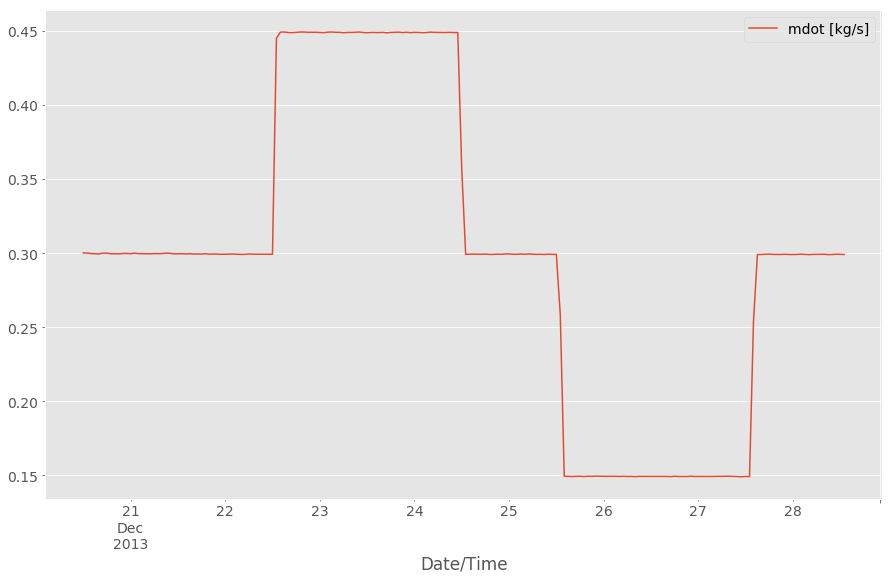

In [8]:
df.plot(y=['mdot [kg/s]'])